In [1]:
# standard imports
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', 15)

In [2]:
# function used to query each type of event from The Graph
def query_theGraph_epoch(raw_query, field_name, url, verbose=False):

    query_parts =raw_query.split(')')
    paginator = ", where: {}" 
    n = 0
    records = []
    while n < 1000:
        if (n == 0):
            # order by blockNumber to get all events, as deafult ordering is by id
            query = 'query '+query_parts[0] + 'orderBy:endBlock, where:{id:"0"})' + query_parts[1]
        else:
            query = 'query '+query_parts[0]+ 'orderBy:endBlock, where: {endBlock_gt: ' + str(indexer) + '})'+query_parts[1]

        if verbose:
            print(query)

        r = requests.post(url, json = {'query':query})

        try:
            d = json.loads(r.content)['data'][field_name]
        except:
            print(r.content)
            errors = json.loads(r.content)['errors']
            print(errors)
            for e in errors:
                print(e['message'])

        #print(f'results {len(d)}')
        records.extend(d)
        #print(f'total {len(records)}')
        try:
            indexer = d[-1]['endBlock']
            print(indexer)
        except:
            print('noblock')
        
        n += 1
        if len(d) < 99 and n > 1:
            break
        
    return pd.DataFrame(records)

In [11]:
#get subgraphs data
url = 'https://api.thegraph.com/subgraphs/name/jesseptao/graph-total-supply-experiment'

epoch_query = '''query{
	epoches(){
    id
    signalledTokens
    stakeDeposited
    totalQueryFees
    curatorQueryFees
    totalRewards
    endBlock
    totalSupply
  }
}
'''

field_name = 'epoches'

epoch_df = query_theGraph_epoch(epoch_query, field_name, url, False)

11453414
12118014
12603172


In [12]:
epoch_df

,id,signalledTokens,stakeDeposited,totalQueryFees,curatorQueryFees,totalRewards,endBlock,totalSupply
0,0,0,0,0,0,0,11453414,10000000000000000000000000000
1,1,0,10000000000000000000,0,0,0,11460060,0
2,2,0,0,0,0,0,11466706,0
3,3,0,2137573000000000000000000,0,0,0,11473352,0
4,4,244919450103834483981271,72326775000000000000000000,0,0,0,11479998,-113142138444810044546497
...,...,...,...,...,...,...,...,...
169,169,0,1225745722570565533936751,4482400276510031286112,417018239204493097320,357394296880463973627247,12576588,352210245957645570695746
170,170,0,156301478327266031202,16081520714497779215621,1525061562870219104674,313638814778513574531779,12583234,310559817884376054041526
171,171,0,759630833495561164397,3447488099094609485009,341301321810366339015,635996690551519925200299,12589880,623107309794229956684401
172,172,0,102697815092630347888302,29281198307551646046194,2881672332566284973678,1191857741695062607146689,12596526,1156713797533048600765740


In [13]:
epoch_df['totalSupply'] = epoch_df['totalSupply'].astype(float)
epoch_df['totalSupply'] = epoch_df['totalSupply']/10e17
epoch_df['total_supply'] = epoch_df['totalSupply'].cumsum()
epoch_df.drop('totalSupply', axis=1, inplace = True)
epoch_df

,id,signalledTokens,stakeDeposited,totalQueryFees,curatorQueryFees,totalRewards,endBlock,total_supply
0,0,0,0,0,0,0,11453414,1.000000e+09
1,1,0,10000000000000000000,0,0,0,11460060,1.000000e+09
2,2,0,0,0,0,0,11466706,1.000000e+09
3,3,0,2137573000000000000000000,0,0,0,11473352,1.000000e+09
4,4,244919450103834483981271,72326775000000000000000000,0,0,0,11479998,9.999887e+08
...,...,...,...,...,...,...,...,...
169,169,0,1225745722570565533936751,4482400276510031286112,417018239204493097320,357394296880463973627247,12576588,1.011547e+09
170,170,0,156301478327266031202,16081520714497779215621,1525061562870219104674,313638814778513574531779,12583234,1.011578e+09
171,171,0,759630833495561164397,3447488099094609485009,341301321810366339015,635996690551519925200299,12589880,1.011640e+09
172,172,0,102697815092630347888302,29281198307551646046194,2881672332566284973678,1191857741695062607146689,12596526,1.011756e+09


In [6]:
from sklearn.linear_model import LinearRegression
supply_lr = LinearRegression().fit(epoch_df[['id']], epoch_df['total_supply'])
print('Coefficient:' + str(supply_lr.coef_), 'Intercept:' + str(supply_lr.intercept_))

Coefficient:[71612.95529424] Intercept:999237203.475498


In [8]:
lr_df = pd.DataFrame(np.zeros(shape=(509,8)), columns=epoch_df.columns, index=range(0,509))
lr_df

,id,signalledTokens,stakeDeposited,totalQueryFees,curatorQueryFees,totalRewards,endBlock,total_supply
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
lr_df['total_supply'] = supply_lr.coef_*lr_df.index + supply_lr.intercept_
lr_df

,id,signalledTokens,stakeDeposited,totalQueryFees,curatorQueryFees,totalRewards,endBlock,total_supply
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.992372e+08
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.993088e+08
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.993804e+08
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.994520e+08
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.995237e+08
...,...,...,...,...,...,...,...,...
504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.035330e+09
505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.035402e+09
506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.035473e+09
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.035545e+09


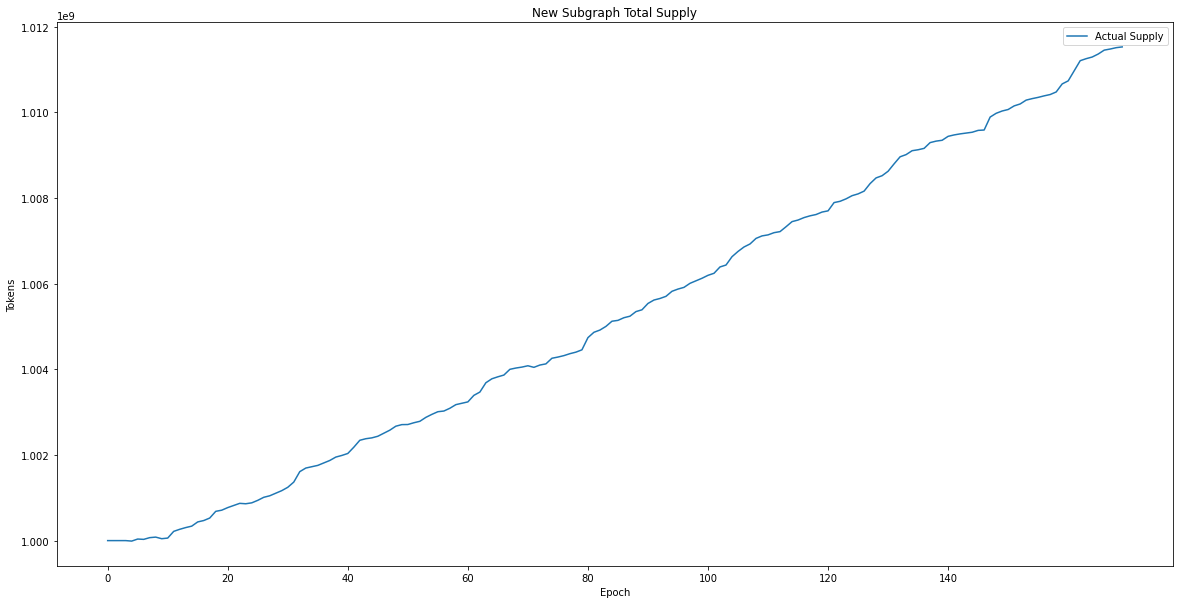

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(epoch_df['id'], epoch_df['total_supply'])
plt.legend(['Actual Supply', 'Predicted Supply'])
plt.xticks(range(0, 160, 20))
plt.xlabel('Epoch')
plt.ylabel('Tokens')
plt.title('New Subgraph Total Supply');

In [24]:
epoch_df.to_csv('./new_subgraph_supply.csv')